In [1]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)

In [2]:
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras import Model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, InputLayer, Input, Conv2D, Flatten, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical
import cv2
import numpy as np
from tqdm import tqdm
import os
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
import pandas as pd

In [3]:
def load_labels(inputPath):
    # initialize the list of column names in the CSV file and then load it using Pandas
    col_list = ["image_id", "class"]
    df = pd.read_csv(inputPath, usecols=col_list)
    return df

# this function is for the sort function in load_gaze_images() function below
def getint(name):
    basename, _ = name.split('.')
    return int(basename)

def read_image(fname, IMAGE_DIMS):
    # read each image in colored
    img = cv2.imread(fname) 
    
    # resize each image
    f_h, f_w = int(IMAGE_DIMS[0]), int(IMAGE_DIMS[1]) # height and width
    img = cv2.resize(img, (f_h, f_w))
    
    # convert image to RGB for ease of training
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img_to_array(img)

    return img

# process and dataset
def load_imageAndLabel(dir, IMAGE_DIMS, dataset_name, label_file):
    batch_data = []
    classes = []
    
    # get the path for the labels. 
    label_path = os.path.join(dir, label_file)
    df_label = load_labels(label_path)
    
    # get the path for all the files in the current sub directory
    img_path = os.path.join(dir, dataset_name) 
    #print(img_path)
    
    # get the file names for all the files
    files = os.listdir(img_path)
    #print(files)

    n_img = len(files)  # get the total number of images
    for i in tqdm(range(n_img)): 
        # get the file path 
        fname = os.path.join(img_path, files[i])
        #print(fname)
        idx = df_label[df_label["image_id"] == files[i]].index.values # get the index of the current image
        clas = df_label["class"].values[idx]
        classes.append(clas)
        img = read_image(fname, IMAGE_DIMS)
        batch_data.append(img) # create batch data
    one = classes.count(0)
    two = classes.count(1)
    three = classes.count(2)
    norm = classes.count(3)
    return np.array(batch_data), np.array(classes)

In [4]:
# mount the google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
input_shape = [80, 80, 3]
dimA, dimB, n_channel = input_shape
tot_n_pixels = dimA * dimB * n_channel
train_dir = '/content/drive/My Drive/GershomProject'
dataset_name = "LungsCancerDataset" 
label_file = "label.csv"

print("[INFO] loading training and test data...")
images, labels = load_imageAndLabel(train_dir, input_shape, dataset_name, label_file)

[INFO] loading training and test data...


100%|██████████| 1000/1000 [00:39<00:00, 25.11it/s]


In [6]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
split = train_test_split(images, labels, test_size=0.2, random_state=42)
(x_train, x_test, y_train, y_test) = split

# Scale or normalize the dataset
print("[INFO] scaling the dataset to range [0,1]...")
x_train = x_train.reshape(-1, dimA, dimB, n_channel).astype('float32') / 255.0 # reshape and normalize the training set
x_test = x_test.reshape(-1, dimA, dimB, n_channel).astype('float32') / 255.0 # reshape and normalize the test set

# one hot encode target values
y_train = to_categorical(y_train.astype('float32'))
y_test = to_categorical(y_test.astype('float32'))

[INFO] scaling the dataset to range [0,1]...


In [7]:
from tensorflow.keras import optimizers

model = Sequential() 

# Convolutional Layer with input shape (224,224,3)
model.add(InputLayer(input_shape=input_shape))

model.add(Conv2D(filters=25, kernel_size= (5,5), activation= 'relu') )
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=25, kernel_size=(5,5), activation='relu' ))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=25, kernel_size=(4,4), activation='relu' ))
model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(units=50, activation='relu'))
model.add(Dropout(rate=0.25))

model.add(Dense(units=4, activation='sigmoid'))

model.compile(optimizer=optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
 
#model.summary()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [8]:
from keras.preprocessing.image import ImageDataGenerator

# Training with data augmentation
def train_generator(x, y, batch_size, shift_fraction=0.1):
 train_datagen = ImageDataGenerator(width_shift_range=shift_fraction,
 height_shift_range=shift_fraction) # shift up to 2 pixel for the dataset
 generator = train_datagen.flow(x, y, batch_size=batch_size)
 while 1:
   x_batch, y_batch = generator.next()
   yield ([x_batch, y_batch])

In [9]:
# train the neural network
EPOCHS = 10
BS = 32
H = model.fit(train_generator(x_train, y_train, BS, 0.1), steps_per_epoch=int(y_train.shape[0] / BS), batch_size=BS, epochs=EPOCHS) 

Epoch 1/10
25/25 [==============================] - 12s 428ms/step - loss: 1.3635 - accuracy: 0.2887
Epoch 2/10
25/25 [==============================] - 11s 429ms/step - loss: 1.3130 - accuracy: 0.3638
Epoch 3/10
25/25 [==============================] - 11s 433ms/step - loss: 1.2860 - accuracy: 0.4288
Epoch 4/10
25/25 [==============================] - 11s 432ms/step - loss: 1.2389 - accuracy: 0.4162
Epoch 5/10
25/25 [==============================] - 11s 431ms/step - loss: 1.2171 - accuracy: 0.4212
Epoch 6/10
25/25 [==============================] - 11s 426ms/step - loss: 1.2088 - accuracy: 0.4363
Epoch 7/10
25/25 [==============================] - 11s 424ms/step - loss: 1.1892 - accuracy: 0.4300
Epoch 8/10
25/25 [==============================] - 11s 444ms/step - loss: 1.1703 - accuracy: 0.4475
Epoch 9/10
25/25 [==============================] - 11s 423ms/step - loss: 1.1449 - accuracy: 0.4625
Epoch 10/10
25/25 [==============================] - 11s 423ms/step - loss: 1.1316 - accura

In [10]:
from sklearn.metrics import classification_report, precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

print("[INFO] evaluating network...")
predictions = model.predict(x=x_test, batch_size=32)

# convert the predicted label to categorical values so that we can calculate the performance metrics
pred_categorical = []
actual_categorical = []  
for i in range(0, len(predictions)):
  pred_categorical.append(np.argmax(predictions[i])) 
  actual_categorical.append(np.argmax(y_test[i]))

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(actual_categorical, pred_categorical)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(actual_categorical, pred_categorical, average='micro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(actual_categorical, pred_categorical, average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(actual_categorical, pred_categorical, average='micro')
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(actual_categorical, pred_categorical)
print('Cohens kappa: %f' % kappa)

# confusion matrix
matrix = confusion_matrix(actual_categorical, pred_categorical)
print(matrix)

[INFO] evaluating network...
Accuracy: 0.480000
Precision: 0.480000
Recall: 0.480000
F1 score: 0.480000
Cohens kappa: 0.268996
[[33  9  0  0]
 [ 5 58  0  1]
 [ 7 33  1  3]
 [ 6 40  0  4]]


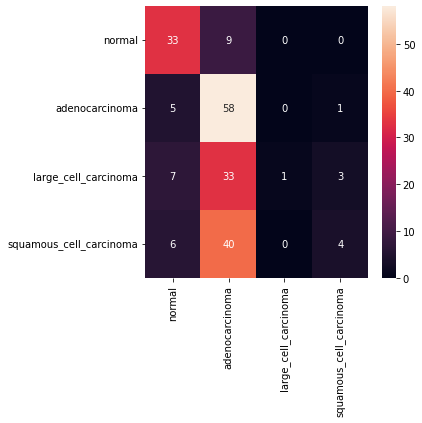

In [11]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(matrix, index=["normal", "adenocarcinoma", "large_cell_carcinoma", "squamous_cell_carcinoma"], 
                     columns=["normal", "adenocarcinoma", "large_cell_carcinoma", "squamous_cell_carcinoma"]) 

plt.figure(figsize = (5,5))
sn.heatmap(df_cm, annot=True)

In [12]:
# print result summary
print(classification_report(actual_categorical, pred_categorical))

              precision    recall  f1-score   support

           0       0.65      0.79      0.71        42
           1       0.41      0.91      0.57        64
           2       1.00      0.02      0.04        44
           3       0.50      0.08      0.14        50

    accuracy                           0.48       200
   macro avg       0.64      0.45      0.37       200
weighted avg       0.61      0.48      0.38       200



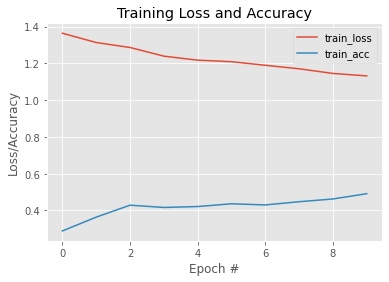

In [13]:
# Display the result
from sklearn.metrics import classification_report
%matplotlib inline 
import matplotlib.pylab as plt

N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()